
# Gemma-2 Few-Shot Inference

In [ ]:
#val_or_test_split = 'val'
val_or_test_split = 'test'

In [ ]:
!pip install --upgrade transformers
!pip install -q datasets sentencepiece accelerate evaluate tiktoken einops flash-attn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 72.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 70.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into acco

In [ ]:
from datasets import load_dataset

hf_site_id = '2024-mcm-everitt-ryan'
dataset_id = f'{hf_site_id}/job-bias-synthetic-human-benchmark-v2'

dataset = load_dataset(dataset_id)
column_names = dataset['train'].column_names

text_col = 'text'
label_cols = [col for col in column_names if col.startswith('label_')]

labels = [label.replace("label_", "") for label in label_cols]

id2label = {idx: label for idx, label in enumerate(labels)}
label2id = {label: idx for idx, label in enumerate(labels)}

# Remove all columns apart from the two needed for multi-class classification
keep_columns = ['context_id', 'synthetic', 'verified', text_col] + label_cols
for split in ["train", "val", "test"]:
    dataset[split] = dataset[split].remove_columns(


Generating train split:   0%|          | 0/4609 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/593 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/584 [00:00<?, ? examples/s]

# Get few-shot examples from Train set

In [ ]:
def get_multiple_true_bias(bias_col):
    other_label_cols = [col for col in label_cols if col != bias_col]
#    multiple_bias_samples = dataset['train'].filter(lambda x: x[bias_col] == True and x['synthetic'] == False and any(x[other_label_col] == True for other_label_col in other_label_cols))
    multiple_bias_samples = dataset['train'].filter(lambda x: x[bias_col] == True and any(x[other_label_col] == True for other_label_col in other_label_cols))
    return multiple_bias_samples

import pandas as pd
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.expand_frame_repr', False)

print("Age and Other")
age_and_other = get_multiple_true_bias('label_age')
print(age_and_other.to_pandas().head(10))
print("Disability and Other")
disability_and_other = get_multiple_true_bias('label_disability')
print(disability_and_other.to_pandas().head(20))
print("Feminine and Other")
feminine_and_other = get_multiple_true_bias('label_feminine')
print(feminine_and_other.to_pandas().head(10))
print("Masculine and Other")
masculine_and_other = get_multiple_true_bias('label_masculine')
print(masculine_and_other.to_pandas().head(15))
print("Racial and Other")
racial_and_other = get_multiple_true_bias('label_racial')
print(racial_and_other.to_pandas().head(10))
print("General and Other")
general_and_other = get_multiple_true_bias('label_general')
print(general_and_other.to_pandas().head(10))

no_bias = dataset['train'].filter(lambda x: x['label_neutral'] == True and x['synthetic'] == False and x['verified'] == True)
print("No Bias")
print(no_bias.to_pandas().head(10))

Age and Other


Filter:   0%|          | 0/4609 [00:00<?, ? examples/s]

   label_age  label_disability  label_feminine  label_general  label_masculine  label_neutral  label_racial  label_sexuality  verified  synthetic                                                                                                                                                                                                     text
0       True             False           False          False             True          False         False            False      True      False  10-15 years web and desktop application development work experience.\n\n- Experienced with JSON, Angular, JQuery, AJAX, XML, and REST web services.\n- Experienced with MongoDB, MySQL, and PostgreS...
1       True             False           False          False            False          False          True            False      True      False  5 years of Materials Planning experience. Worked with Global MNC.\n\nAbout Our Client\nOur client is a global manufacturer of home appliances.\n\nJob Descripti

Filter:   0%|          | 0/4609 [00:00<?, ? examples/s]

    label_age  label_disability  label_feminine  label_general  label_masculine  label_neutral  label_racial  label_sexuality  verified  synthetic                                                                                                                                                                                                     text
0       False              True           False          False             True          False         False            False      True      False  3 MONTH CONTRACT. IMMEDIATE START. RESIDENTIAL TO PORT HEDLAND.\n\nAbout the Role:\nMy client is seeking labourers to join their team for a civil project. For this role, you will need to be physic...
1        True              True           False           True             True          False         False            False      True      False  About the business\n\nLumber Punks Axe Throwing is more than an activity, it's a movement. We bring the Punk ethos to everything we do and make sure every g

Filter:   0%|          | 0/4609 [00:00<?, ? examples/s]

   label_age  label_disability  label_feminine  label_general  label_masculine  label_neutral  label_racial  label_sexuality  verified  synthetic                                                                                                                                                                                                     text
0      False             False            True          False            False          False         False             True      True      False  Summary\n\nPomellato is the first global luxury Italian fashion fine jeweler, unconventional, colourful. Established in Milan in 1967, Pomellato stands out on the international scene for its uniqu...
1      False             False            True           True            False          False         False            False      True      False  About Ryman Retirement Villages\n\nRyman Healthcare's Jane Winstone Retirement Village has a strong family and community focus. With a welcoming atmosphere, ou

Filter:   0%|          | 0/4609 [00:00<?, ? examples/s]

    label_age  label_disability  label_feminine  label_general  label_masculine  label_neutral  label_racial  label_sexuality  verified  synthetic                                                                                                                                                                                                     text
0       False              True           False          False             True          False         False            False      True      False  3 MONTH CONTRACT. IMMEDIATE START. RESIDENTIAL TO PORT HEDLAND.\n\nAbout the Role:\nMy client is seeking labourers to join their team for a civil project. For this role, you will need to be physic...
1        True             False           False          False             True          False         False            False      True      False  10-15 years web and desktop application development work experience.\n\n- Experienced with JSON, Angular, JQuery, AJAX, XML, and REST web services.\n- Exper

Filter:   0%|          | 0/4609 [00:00<?, ? examples/s]

   label_age  label_disability  label_feminine  label_general  label_masculine  label_neutral  label_racial  label_sexuality  verified  synthetic                                                                                                                                                                                                     text
0       True             False           False          False            False          False          True            False      True      False  5 years of Materials Planning experience. Worked with Global MNC.\n\nAbout Our Client\nOur client is a global manufacturer of home appliances.\n\nJob Description\n- Handle activities related to th...
1      False             False           False           True            False          False          True            False      True      False  You will be a pro-active self-starter with a naturally engaging demeanor and confidence in communicating with clients at senior levels. \n\nWe are looking for 

Filter:   0%|          | 0/4609 [00:00<?, ? examples/s]

   label_age  label_disability  label_feminine  label_general  label_masculine  label_neutral  label_racial  label_sexuality  verified  synthetic                                                                                                                                                                                                     text
0      False             False           False           True            False          False          True            False      True      False  You will be a pro-active self-starter with a naturally engaging demeanor and confidence in communicating with clients at senior levels. \n\nWe are looking for a native Spanish and/or Portuguese sp...
1       True              True           False           True             True          False         False            False      True      False  About the business\n\nLumber Punks Axe Throwing is more than an activity, it's a movement. We bring the Punk ethos to everything we do and make sure every gues

Filter:   0%|          | 0/4609 [00:00<?, ? examples/s]

No Bias
   label_age  label_disability  label_feminine  label_general  label_masculine  label_neutral  label_racial  label_sexuality  verified  synthetic                                                                                                                                                                                                     text
0      False             False           False          False            False           True         False            False      True      False  5-7 years of relevant work experience.  \nExcellent verbal and written communication skills.  \nOutgoing and proactive personality.  \n\nIdeally, you also have:  \n- Good knowledge of how accounti...
1      False             False           False          False            False           True         False            False      True      False  Experienced Heavy Rigid Drivers\n\nABOUT THE CLIENT\nAction Workforce has partnered up with a very reputable company based in South Brisbane. This comp

In [ ]:
def get_examples():
    examples = []

    text = no_bias[1]['text']
    label = 'neutral'
    examples.append({'answer':label, 'job_description':text})

    text = racial_and_other[9]['text']
    label = 'age, racial, sexuality'
    examples.append({'answer':label, 'job_description':text})

    return examples

examples = get_examples()

# Prompt Formatting & Data preprocessing

Inspiration from https://medium.com/@olaf.lenzmann/mastering-llms-for-complex-classification-tasks-64f0bda2edf3

In [ ]:
system = "You are an analyst of job postings. Your task is to detect implicit bias, if present.\n"
instruction = "Analyse the job posting for implicit bias. The bias categories are age, disability, feminine, masculine, racial, sexuality, general.  Return the appropriate label only when absolutely sure that the particular bias category is present in the text.\n"
closing_instruction = "Does the job posting contain any implicit bias? Please respond in the format of 'Labels: <labels>' where the possible labels are zero or more from the choices of age, disability, feminine, masculine, racial, sexuality, general. If no bias is detected please return 'Labels: neutral'. No further explanation is required."

def construct_prompt_few_shot (query_job_description):
    messages = []
    for i, ex in enumerate(examples):
        job = ex['job_description']
        answer = ex['answer']

        evidence = f"Job Posting: \n {job} \n ===END=== \n"
        if i == 0:
            content = system + instruction + evidence + closing_instruction
        else:
            content = evidence + closing_instruction

        messages.append({"role": "user", "content": content})
        messages.append({"role": "assistant", "content": "Labels: " + answer})

    evidence = f"Job Posting: \n {query_job_description} \n ===END=== \n"
    content = evidence + closing_instruction
    messages.append({"role": "user", "content": content})
    return messages

In [ ]:
def get_formatted_prompt(job_description):
    msgs = construct_prompt_few_shot(job_description)
    return msgs

In [ ]:
import numpy as np

def preprocess_data(sample):
#    print(sample)
    # take a batch of texts
    text = sample[text_col]
    sample['prompt'] = list(map(get_formatted_prompt, sample[text_col]))
    # add labels
    labels_batch = {k: sample[k] for k in sample.keys() if k in label_cols}
    # create numpy array of shape (batch_size, num_labels)
    labels_matrix = np.zeros((len(text), len(label_cols)), dtype=int)
    # fill numpy array
    for idx, label in enumerate(label_cols):
        labels_matrix[:, idx] = labels_batch[label]

    sample["labels"] = labels_matrix.tolist()
    return sample

processed_dataset = dataset.map(preprocess_data, batched=True, remove_columns=[col for col in dataset['val'].column_names if col not in ['prompt','labels']])


# Label extraction

In [ ]:
import re

def extract_labels(text):
    # Define the regular expression pattern to capture the needed parts
    pattern = r'\bLabels: \s*(?P<labels>[^\n]+)'

    # Search the text for matches
    match = re.search(pattern, text, re.DOTALL)

    if match:
        # Extract the 'answer' part and split it into a list of words
        labels_text = match.group('labels')
        # Strip whitespace and split by comma
        answer_list = [label.strip() for label in labels_text.split(',')]
        return answer_list
    else:
        return None

def responses_to_predictions(responses):
    #Extract labels
    label_set = set(labels) # Just for efficiency
    predictions = []
    not_parsed = []
    for i, res in enumerate(responses):
        for seq in res:
            predicted = np.zeros((len(labels),), dtype=int)
            generated_text = seq['generated_text']

            words_list = extract_labels(generated_text)
            if words_list is not None:
                for idx, l in enumerate(labels):
                    if l in words_list:
                        predicted[idx] = 1

                predictions.append(predicted)
            else:
                not_parsed.append(i)
    return predictions, not_parsed


# Metrics & Result display

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score

# Define custom metric function
def compute_metrics(y_pred, y_true):
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    f1_micro = f1_score(y_true=y_true, y_pred=y_pred, average='micro', zero_division=0.0)
    f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro', zero_division=0.0)
    f1_samples = f1_score(y_true=y_true, y_pred=y_pred, average='samples', zero_division=0.0)
    f1_weighted = f1_score(y_true=y_true, y_pred=y_pred, average='weighted', zero_division=0.0)

    precision_micro = precision_score(y_true=y_true, y_pred=y_pred, average='micro')
    recall_micro = recall_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc_micro = roc_auc_score(y_true=y_true, y_score=y_pred, average='micro')
    # return as dictionary
    metrics = {
        'accuracy': accuracy,
        f'f1_micro': f1_micro,
        f'f1_macro': f1_macro,
        f'f1_samples': f1_samples,
        f'f1_weighted': f1_weighted,
        f'precision_micro': precision_micro,
        f'recall_micro': recall_micro,
        f'roc_auc_micro': roc_auc_micro}
    return metrics

# Function to calculate true positives, false positives, true negatives, and false negatives
def calculate_counts(true_labels, predicted_labels):
    tp = np.sum((true_labels == 1) & (predicted_labels == 1), axis=0)
    fp = np.sum((true_labels == 0) & (predicted_labels == 1), axis=0)
    tn = np.sum((true_labels == 0) & (predicted_labels == 0), axis=0)
    fn = np.sum((true_labels == 1) & (predicted_labels == 0), axis=0)
    return tp, fp, tn, fn

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def print_metrics(metrics):
    print("Evaluation Metrics:")
    print("===================")
    for metric, value in metrics.items():
        print(f"{metric.replace('_', ' ').capitalize():<20}: {value:.4f}")

def heatmap_TP_FP_TN_FN(tp, fp, tn, fn):
    data = {
        'True Positive': tp,
        'False Positive': fp,
        'True Negative': tn,
        'False Negative': fn
    }

    df = pd.DataFrame(data, index=labels)

    # Plot the data using seaborn
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.T, annot=True, cmap='Blues', fmt='d', linewidths=.5)
    plt.title('Multi-Label Confusion Matrix Breakdown by Class')
    plt.xlabel('Labels')
    plt.ylabel('Counts')
    plt.show()

# Model, Tokenizer & Pipeline

In [ ]:
# Load the model and tokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name = "google/gemma-2-9b-it"
#tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left', add_eos_token=True, add_bos_token=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype="auto", trust_remote_code=True)

model.half() #this is needed if GPU ram is less than approx 26gb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


tokenizer_config.json:   0%|          | 0.00/40.6k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/857 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/39.1k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 3584, padding_idx=0)
    (layers): ModuleList(
      (0-41): 42 x Gemma2DecoderLayer(
        (self_attn): Gemma2SdpaAttention(
          (q_proj): Linear(in_features=3584, out_features=4096, bias=False)
          (k_proj): Linear(in_features=3584, out_features=2048, bias=False)
          (v_proj): Linear(in_features=3584, out_features=2048, bias=False)
          (o_proj): Linear(in_features=4096, out_features=3584, bias=False)
          (rotary_emb): Gemma2RotaryEmbedding()
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear(in_features=3584, out_features=14336, bias=False)
          (up_proj): Linear(in_features=3584, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=3584, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm()
        (post_attention_layernorm): Gemma2RMSNorm()
        (pre_feedforwa

In [ ]:
from transformers import pipeline
import torch

pipeline = pipeline("text-generation", model=model, tokenizer=tokenizer, torch_dtype=torch.float16, device=device)


# Run Inference - Validation or Test

Map:   0%|          | 0/4609 [00:00<?, ? examples/s]

Map:   0%|          | 0/593 [00:00<?, ? examples/s]

Map:   0%|          | 0/584 [00:00<?, ? examples/s]

Num not parsed: 0
Evaluation Metrics:
Accuracy            : 0.4161
F1 micro            : 0.5234
F1 macro            : 0.5207
F1 samples          : 0.5469
F1 weighted         : 0.5207
Precision micro     : 0.4740
Recall micro        : 0.5844
Roc auc micro       : 0.7407


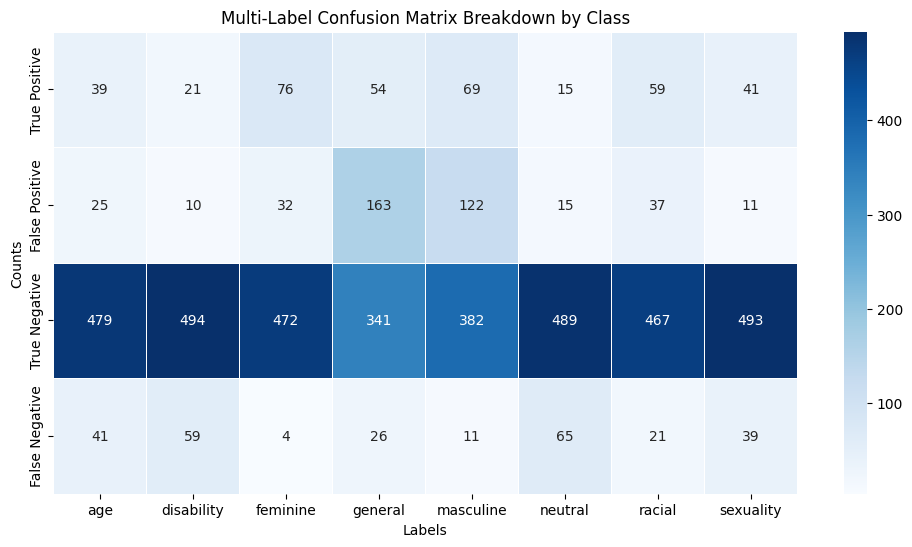

              precision    recall  f1-score   support

         age       0.61      0.49      0.54        80
  disability       0.68      0.26      0.38        80
    feminine       0.70      0.95      0.81        80
     general       0.25      0.68      0.36        80
   masculine       0.36      0.86      0.51        80
     neutral       0.50      0.19      0.27        80
      racial       0.61      0.74      0.67        80
   sexuality       0.79      0.51      0.62        80

   micro avg       0.47      0.58      0.52       640
   macro avg       0.56      0.58      0.52       640
weighted avg       0.56      0.58      0.52       640
 samples avg       0.52      0.60      0.55       640



In [ ]:
from sklearn.metrics import classification_report
label_set = set(labels)

#num_tests=50
#data_to_test = processed_dataset[val_or_test_split].select(range(num_tests))
data_to_test = processed_dataset[val_or_test_split]

responses = pipeline(data_to_test['prompt'],
                    max_new_tokens=100,
                    pad_token_id=tokenizer.eos_token_id,
                    return_full_text=False,
                    do_sample=False   #With half precision and batch>1, there is an error if so_sampling==True
                    )

#Extract labels
predictions, not_parsed = responses_to_predictions(responses)

print(f"Num not parsed: {len(not_parsed)}")

#There still may be a few unparseable responses. Remove these from the ground truth labels
#In testing, this has always been zero, therefore results are valid.
truth_labels = data_to_test['labels']
filtered_truth_labels = [label for idx, label in enumerate(truth_labels) if idx not in not_parsed]

metrics = compute_metrics(predictions, filtered_truth_labels)
print_metrics(metrics)

tp, fp, tn, fn = calculate_counts(np.array(filtered_truth_labels), np.array(predictions))
heatmap_TP_FP_TN_FN(tp, fp, tn, fn)

print(classification_report(filtered_truth_labels, predictions, target_names=labels))

In [ ]:
#responses